In [1]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.utils.time_series import TimeSeries
from ts_datasets.forecast import M4


100%|██████████| 414/414 [00:00<00:00, 621.77it/s]


Has missing data: False


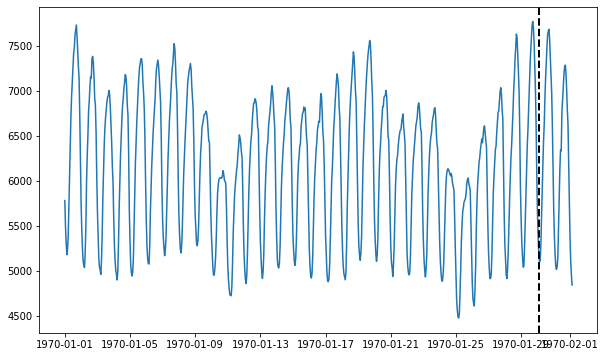

700 points in train split, 48 points in test split.


In [2]:
# Load the time series
# time_series is a time-indexed pandas.DataFrame
# trainval is a time-indexed pandas.Series indicating whether each timestamp is for training or testing
time_series, metadata = M4(subset="Hourly")[5]
trainval = metadata["trainval"]

# Is there any missing data?
timedeltas = np.diff(time_series.index)
print(f"Has missing data: {any(timedeltas != timedeltas[0])}")

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(time_series[trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

# Split the time series into train/test splits, and convert it to Merlion format
train_data = TimeSeries.from_pd(time_series[trainval])
test_data  = TimeSeries.from_pd(time_series[~trainval])
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")


In [99]:
import jax.numpy as jnp

def relu(x):
    return jnp.maximum(0.0, x)

def mlp(params, inputs):
# A multi-layer perceptron, i.e. a fully-connected neural network.
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b  # Linear transform
        inputs = jnp.tanh(outputs)            # Nonlinearity
        # inputs = relu(outputs)
    return outputs

In [100]:
def nn_dynamics(state, time, params):
    state_and_time = jnp.hstack([state, jnp.array(time)])
    return mlp(params, state_and_time)

In [101]:
from jax.experimental.ode import odeint

def odenet(params, inputs):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, inputs, start_and_end_times, params, atol=1e-9, rtol=1e-9)
    return final_state

In [102]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

# Preparing training data

In [134]:
in_data = np.array(train_data.time_stamps)[:10]
out_data = train_data.to_pd()['H6'].values[:10]
in_data = in_data / 3600
out_data = (out_data - out_data.max())/out_data.std()

In [136]:
inputs = jnp.reshape(in_data, (in_data.shape[0], 1))
targets = jnp.reshape(out_data, (out_data.shape[0], 1))
# inputs
# inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
# targets = inputs**3 + 0.1 * inputs

# Creating and initializing model

In [137]:
from jax.config import config  
config.update("jax_debug_nans", True)

In [144]:
import numpy.random as npr
from jax import jit, grad

# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 20, 1]

def odenet_loss(params, inputs, targets):
    preds = batched_odenet(params, inputs)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def odenet_update(params, inputs, targets):
    grads = grad(odenet_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db)
                  for (w, b), (dw, db) in zip(params, grads)]



In [158]:
# Initialize and train ODE-Net.
param_scale = 1.0
step_size = 0.01
train_iters = 6000

odenet_params = init_random_params(param_scale, odenet_layer_sizes)
min_loss = 1e9

# Training!

In [159]:
import tqdm
for i in tqdm.tqdm(range(train_iters)):
    odenet_params = odenet_update(odenet_params, inputs, targets)
    loss = odenet_loss(odenet_params, inputs, targets)
    if loss < min_loss:
        min_loss = loss
        best_iter = i
        best_params = odenet_params
        # print(i, min_loss)

100%|██████████| 6000/6000 [11:23<00:00,  8.78it/s]


In [160]:
print(best_iter, min_loss)

5999 0.10434993


In [161]:
# batched_odenet(odenet_params, inputs)

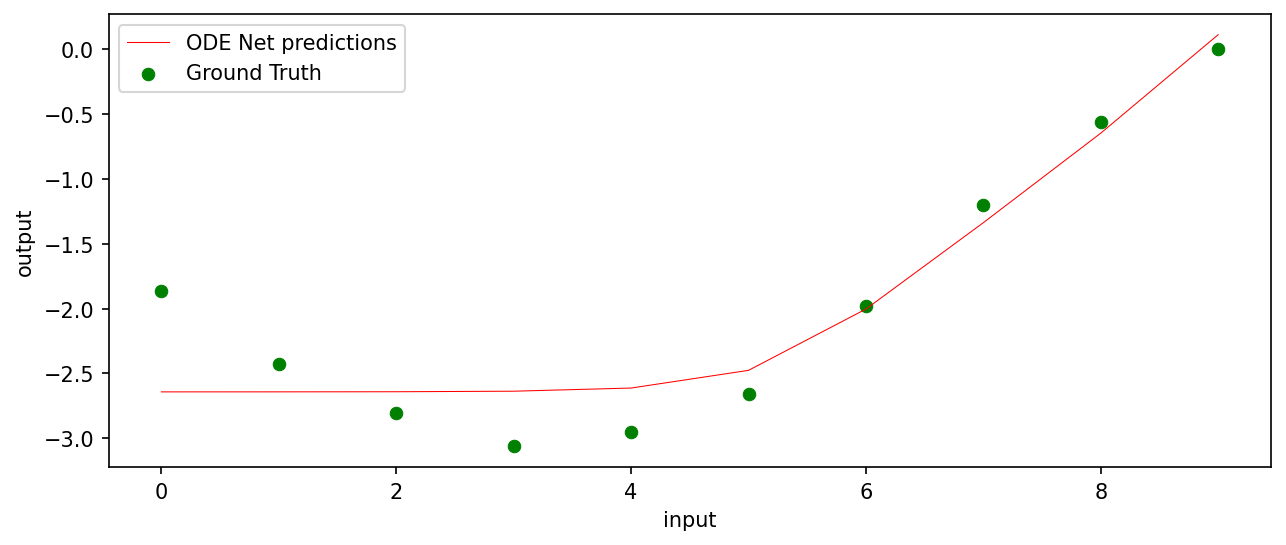

In [162]:
# Plot resulting model.
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
# fine_inputs = jnp.reshape(scaler.transform(np.array(train_data.time_stamps[0:10]).reshape(-1,1)), (10, 1))
# fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(inputs, batched_odenet(best_params, inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(("ODE Net predictions","Ground Truth"))